# Best Photo Selection

## Giving a score for how good or bad a photograph is.

### Using [Flickr Image dataset](https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset)

Train data is based on:

*   7000 good photos.
*   7000 synthetic bad photos, generated from the other photos in the Flickr Image dataset.

### Step 0: Load Kaggle Datasets Directly into Google Colab

Upload the kaggle.json file (an API token) to the colab (Follow this [article](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/) to see how to do that) and run the following code:

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.15G/8.16G [02:56<00:00, 56.7MB/s]
100% 8.16G/8.16G [02:56<00:00, 49.6MB/s]


In [6]:
! unzip flickr-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

### Step 1: Generating bad photos from good photos

#### Choosing random images from a folder

In [7]:
# loading libraries
import cv2
import numpy as np
import os, random
from PIL import Image

In [8]:
def choose_photos(filename, n_photos=-1):
    if isinstance(filename, set):
        photos = filename
    else:
        photos = set(os.listdir(folder))
    if n_photos == -1:
        return photos
    number_files = len(photos)
    if number_files < n_photos:
        return 'number of photos is larger than the photos in the folder/set'
    chosen_photos = set(random.sample(photos, n_photos))
    photos = photos - chosen_photos
    return photos, chosen_photos

In [9]:
folder = r"/content/flickr30k_images/flickr30k_images"
photos = choose_photos(folder)

In [10]:
len(photos)

31785

#### Creating "good" and "bad" folders

##### train dataset

In [11]:
try:
    os.mkdir('train') 
except OSError as error: 
    print(error)

In [12]:
try:
    os.mkdir('train/good') 
except OSError as error: 
    print(error)

In [13]:
try:
    os.mkdir('train/bad')
except OSError as error: 
    print(error)

##### test dataset

In [14]:
try:
    os.mkdir('test') 
except OSError as error: 
    print(error)

In [15]:
try:
    os.mkdir('test/good') 
except OSError as error: 
    print(error)

In [16]:
try:
    os.mkdir('test/bad') 
except OSError as error: 
    print(error)

#### Copying the random chosen images into the "good" folder

In [17]:
import shutil

##### train set

In [18]:
photos, good_photos = choose_photos(photos, 7000)

In [19]:
print('Chosen photos:', len(good_photos))
print('Remaining number of photos:', len(photos))
bool(photos & good_photos)

Chosen photos: 7000
Remaining number of photos: 24785


False

In [20]:
for photo in good_photos:
    shutil.copy(folder + '/' + photo, 'train/good')

##### test set

In [21]:
photos, good_photos = choose_photos(photos, 700)

In [22]:
print('Chosen photos:', len(good_photos))
print('Remaining number of photos:', len(photos))
bool(photos & good_photos)

Chosen photos: 700
Remaining number of photos: 24085


False

In [23]:
for photo in good_photos:
    shutil.copy(folder + '/' + photo, 'test/good')

#### Generating bad photos

In [24]:
# motion blur filter
#size - in pixels, size of motion blur
#angle - in degrees, direction of motion blur
def apply_motion_blur(image, size, angle):
    k = np.zeros((size, size), dtype=np.float32)
    k[ (size-1)// 2 , :] = np.ones(size, dtype=np.float32)
    k = cv2.warpAffine(k, cv2.getRotationMatrix2D( (size / 2 -0.5 , size / 2 -0.5 ) , angle, 1.0), (size, size) )
    k = k * (1.0 / np.sum(k))
    return cv2.filter2D(image, -1, k)

In [25]:
# random gaussian blur outer circle filter
def random_blur_out(image, radius=100):
    img_size = (image.shape[0], image.shape[1], 3)
    blurred_img = cv2.GaussianBlur(image, (21, 21), 0)
    mask = np.zeros(img_size, dtype=np.uint8)
    x, y = (random.randint(0, img_size[0]-radius), random.randint(0, img_size[1]-radius))
    mask = cv2.circle(mask, (x, y), radius, (255, 255, 255), -1)
    return np.where(mask==np.array([255, 255, 255]), image, blurred_img)

In [26]:
# random gaussian blur inner circle filter
def random_blur_in(image, radius):
    img_size = (image.shape[0], image.shape[1], 3)
    blurred_img = cv2.GaussianBlur(image, (21, 21), 0)
    mask = np.zeros(img_size, dtype=np.uint8)
    x, y = (random.randint(0, img_size[0]-radius), random.randint(0, img_size[1]-radius))
    mask = cv2.circle(mask, (x, y), radius, (255, 255, 255), -1)
    return np.where(mask==np.array([0, 0, 0]), image, blurred_img)

In [27]:
# illumination filter
def adjust_gamma(image, gamma=0.5):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [28]:
# light source filter
def fake_light(image, size=0.5):
    img_size = (image.shape[0], image.shape[1], 3)
    mask = np.zeros(img_size, np.uint8)

    lightsource = cv2.imread('lightsource.png')
    lightsource_size = (int(img_size[0]*size), int(img_size[1]*size))
    lightsource = cv2.resize(lightsource, lightsource_size)
    
    mask = Image.fromarray(np.uint8(mask))
    lightsource = Image.fromarray(np.uint8(lightsource))

    x, y = (random.randint(0, img_size[0]-lightsource_size[0]), random.randint(0, img_size[1]-lightsource_size[1]))

    mask.paste(lightsource, (x, y))
    mask = np.asarray(mask)

    return cv2.addWeighted(img, 1, mask, 1, 0)

In [29]:
def apply_filter(image, filter_name='motion_blur'):
    if filter_name == 'motion_blur':
        return apply_motion_blur(image, 10, 90)
    if filter_name == 'random_blur_out':
        return random_blur_out(image, radius=100)
    if filter_name == 'random_blur_in':
        return random_blur_in(image, radius=100)
    if filter_name == 'bright':
        return adjust_gamma(image, 3)
    if filter_name == 'dark':
        return adjust_gamma(image, 0.3)
    if filter_name == 'light':
        return fake_light(image)
    if filter_name == 'mix':
        return adjust_gamma(apply_motion_blur(fake_light(image), 10, 90), 3)

##### train set

In [30]:
filters = ['motion_blur', 'random_blur_out', 'random_blur_in', 'bright', 'dark', 'light', 'mix']

n_filtered_images = 1000
for fil in filters:
    photos, chosen_photos_to_be_filtered = choose_photos(photos, n_filtered_images)
    for img_file in chosen_photos_to_be_filtered:
        img = cv2.imread(folder + '/' + img_file)
        cv2.imwrite('train/bad/' + img_file[:-4] + '_' + fil + '.jpg', apply_filter(img, filter_name=fil))
    print('Generated ' + str(len(chosen_photos_to_be_filtered)) + ' for the ' + fil + ' filter')
print('Generated total of ' + str(n_filtered_images*len(filters)) + ' bad images')

Generated 1000 for the motion_blur filter
Generated 1000 for the random_blur_out filter
Generated 1000 for the random_blur_in filter
Generated 1000 for the bright filter
Generated 1000 for the dark filter
Generated 1000 for the light filter
Generated 1000 for the mix filter
Generated total of 7000 bad images


##### test set

In [31]:
n_filtered_images = 100
for fil in filters:
    photos, chosen_photos_to_be_filtered = choose_photos(photos, n_filtered_images)
    for img_file in chosen_photos_to_be_filtered:
        img = cv2.imread(folder + '/' + img_file)
        cv2.imwrite('test/bad/' + img_file[:-4] + '_' + fil + '.jpg', apply_filter(img, filter_name=fil))
    print('Generated ' + str(len(chosen_photos_to_be_filtered)) + ' for the ' + fil + ' filter')
print('Generated total of ' + str(n_filtered_images*len(filters)) + ' bad images')

Generated 100 for the motion_blur filter
Generated 100 for the random_blur_out filter
Generated 100 for the random_blur_in filter
Generated 100 for the bright filter
Generated 100 for the dark filter
Generated 100 for the light filter
Generated 100 for the mix filter
Generated total of 700 bad images


### Step 2: Data preparation

In [32]:
from keras.preprocessing.image import ImageDataGenerator
img_gen = ImageDataGenerator(validation_split=0.2)

In [33]:
train_data = img_gen.flow_from_directory(
    'train/',
    class_mode='binary',
    batch_size=64,
    target_size=(224, 224),
    subset='training',
)

Found 11200 images belonging to 2 classes.


In [34]:
valid_data = img_gen.flow_from_directory(
    'train/',
    class_mode='binary',
    batch_size=64,
    target_size=(224, 224),
    subset='validation',
)

Found 2800 images belonging to 2 classes.


In [35]:
print('there are 11200 images in the training set and', len(train_data), 'mini-batches')
print('there are 2800 images in the validation set and', len(valid_data), 'mini-batches')

there are 11200 images in the training set and 175 mini-batches
there are 2800 images in the validation set and 44 mini-batches


### Step 3: A baseline model using a VGG16 model (CNN)

In [36]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [37]:
import tensorflow
vgg_model = tensorflow.keras.applications.vgg16.VGG16(include_top=False, input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 4s 0us/step


In [38]:
print('there are', len(vgg_model.layers), 'layers in vgg_model')
print('there are', vgg_model.count_params(), 'parameters in vgg_model')

there are 19 layers in vgg_model
there are 14714688 parameters in vgg_model


In [39]:
print('input shape is', vgg_model.input_shape)
print('output shape is', vgg_model.output_shape)
vgg_model.summary()

input shape is (None, 224, 224, 3)
output shape is (None, 7, 7, 512)
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

In [40]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential(
    vgg_model.layers + 
    [
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [41]:
assert model.count_params() == 17926209

In [42]:
vgg_model.trainable=False

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [44]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [45]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [46]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.fit(train_data, validation_data=valid_data, batch_size=16, steps_per_epoch=len(train_data), validation_steps=len(valid_data), epochs=10, callbacks=[cp_callback])

Epoch 1/10
175/175 [==============================] - ETA: 0s - loss: 1.1806 - accuracy: 0.6812
Epoch 1: saving model to training_1/cp.ckpt
175/175 [==============================] - 112s 549ms/step - loss: 1.1806 - accuracy: 0.6812 - val_loss: 0.4447 - val_accuracy: 0.7679
Epoch 2/10
175/175 [==============================] - ETA: 0s - loss: 0.3648 - accuracy: 0.8254
Epoch 2: saving model to training_1/cp.ckpt
175/175 [==============================] - 86s 489ms/step - loss: 0.3648 - accuracy: 0.8254 - val_loss: 0.4356 - val_accuracy: 0.8011
Epoch 3/10
175/175 [==============================] - ETA: 0s - loss: 0.2476 - accuracy: 0.8890
Epoch 3: saving model to training_1/cp.ckpt
175/175 [==============================] - 85s 486ms/step - loss: 0.2476 - accuracy: 0.8890 - val_loss: 0.4863 - val_accuracy: 0.7943
Epoch 4/10
175/175 [==============================] - ETA: 0s - loss: 0.1886 - accuracy: 0.9195
Epoch 4: saving model to training_1/cp.ckpt
175/175 [============================

In [47]:
os.listdir(checkpoint_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

#### Pickling the model

In [48]:
import pickle
pickle.dump(model, open('training_1/model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://179984b0-6bf2-4a10-98ae-dd2b42c84450/assets


#### Zip the model and train data and download the files to local computer

In [49]:
!zip -r /content/model.zip /content/training_1
!zip -r /content/train.zip /content/train
!zip -r /content/test.zip /content/test

Streaming output truncated to the last 5000 lines.
  adding: content/train/good/2380765956.jpg (deflated 0%)
  adding: content/train/good/4684538785.jpg (deflated 4%)
  adding: content/train/good/3308663039.jpg (deflated 0%)
  adding: content/train/good/3560977956.jpg (deflated 0%)
  adding: content/train/good/3272002857.jpg (deflated 0%)
  adding: content/train/good/5057010159.jpg (deflated 10%)
  adding: content/train/good/4813608480.jpg (deflated 1%)
  adding: content/train/good/697778778.jpg (deflated 0%)
  adding: content/train/good/2646673527.jpg (deflated 0%)
  adding: content/train/good/241346508.jpg (deflated 0%)
  adding: content/train/good/3359166012.jpg (deflated 0%)
  adding: content/train/good/2624979508.jpg (deflated 0%)
  adding: content/train/good/3243020805.jpg (deflated 0%)
  adding: content/train/good/2817230861.jpg (deflated 0%)
  adding: content/train/good/3159092624.jpg (deflated 0%)
  adding: content/train/good/3458215674.jpg (deflated 0%)
  adding: content/trai

In [50]:
from google.colab import files
files.download("/content/model.zip")
files.download("/content/train.zip")
files.download("/content/test.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Step 4: testing the model

In [51]:
test_data = img_gen.flow_from_directory(
    'test/',
    target_size=(224, 224),
    class_mode=None,
    shuffle=False,
)

Found 1399 images belonging to 2 classes.


In [52]:
def evaluate(img_fname):
    img = image.load_img(img_fname, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)[0][0]
    pred_class = 'good' if pred > 0.5 else 'bad'
    pred = pred if pred_class == 'good' else 1 - pred
    print('Predicted:', pred_class, 'with prediction (confidence) of ' + str(round(pred, 3)))
    plt.imshow(img)
    plt.show()

Predicted: bad with prediction (confidence) of 0.643


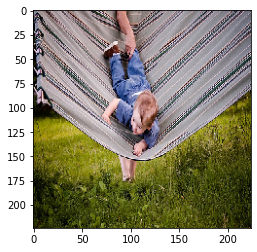

Predicted: good with prediction (confidence) of 0.843


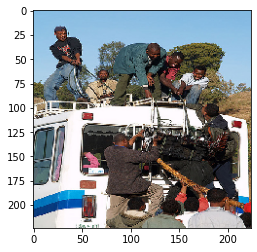

Predicted: bad with prediction (confidence) of 1.0


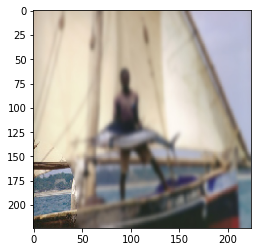

Predicted: good with prediction (confidence) of 0.999


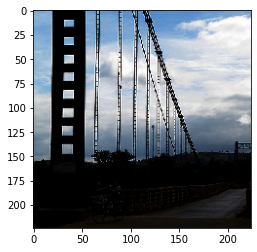

Predicted: bad with prediction (confidence) of 0.996


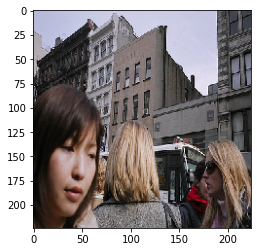

Predicted: bad with prediction (confidence) of 0.882


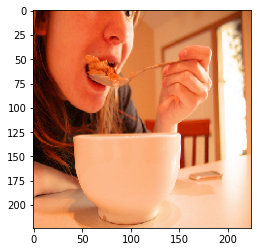

Predicted: bad with prediction (confidence) of 1.0


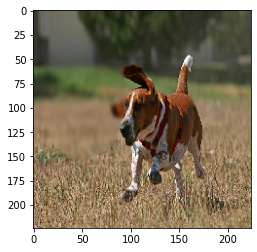

Predicted: bad with prediction (confidence) of 0.993


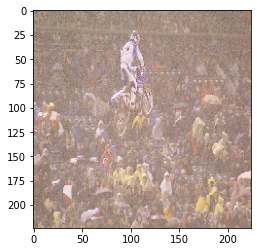

Predicted: good with prediction (confidence) of 0.988


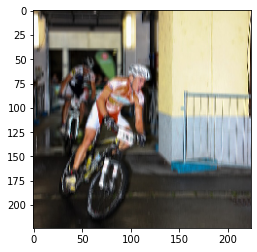

Predicted: bad with prediction (confidence) of 1.0


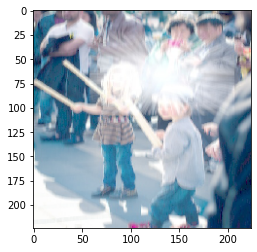

In [53]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import random

for img in random.sample(test_data.filenames, 10):
    evaluate('test/' + str(img))